In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import seaborn as sns;
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.autograd import Function


In [2]:
cwd = os.getcwd()
cwd

'/Users/anna/Desktop/twitter/code'

In [3]:
#load dataset
df = pd.read_csv(os.path.join(cwd, 'montrealbikes.csv'))


In [4]:
# delete 1 column
df.drop('Unnamed: 1', axis = 1, inplace = True)

In [5]:
cols_lanes = df.columns[1:]


In [6]:
df.columns

Index(['Date', 'Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)',
       'Maisonneuve_1', 'Maisonneuve_2', 'Maisonneuve_3', 'Notre-Dame', 'Parc',
       'Parc U-Zelt Test', 'PierDup', 'Pont_Jacques_Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent U-Zelt Test', 'Saint-Urbain',
       'Totem_Laurier', 'University', 'Viger'],
      dtype='object')

This rows correspond to days of the year 2015 and the columns are the bike lanes in Montreal. The numbers in the cells are the number of bikes that used that lane.

In [7]:
df.head()

,Date,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,58,12,4,17,33.0,49,21,16,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,75,7,5,15,30.0,113,27,9,32,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,79,7,3,7,30.0,107,36,12,18,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,10,1,21,0,10.0,35,29,1,0,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,42,0,2,0,27.0,90,21,1,1,...,NaN,0,5,49,20,NaN,0,41,56,10


### EDA

In [8]:
df.describe()

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,Parc U-Zelt Test,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
count,319.000000,319.000000,319.000000,319.000000,62.000000,319.000000,319.000000,319.000000,319.000000,52.000000,...,209.000000,319.000000,319.000000,319.000000,319.000000,50.000000,319.000000,319.000000,319.000000,319.000000
mean,2915.398119,2212.909091,2859.485893,1167.388715,89.935484,2208.031348,1011.175549,1137.316614,1754.257053,2090.250000,...,2164.578947,2207.626959,2939.294671,1477.206897,207.476489,4563.180000,1387.119122,1903.363636,2023.708464,295.347962
std,2276.281648,1832.808709,2337.531344,960.020397,51.886974,2452.475658,917.450049,991.065590,1415.004315,972.740577,...,1049.224968,1660.936427,2105.774880,1254.990855,231.009131,1667.554469,1070.781272,1376.375755,1632.368428,248.947624
min,10.000000,0.000000,0.000000,0.000000,10.000000,2.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,0.000000,0.000000,1554.000000,0.000000,20.000000,6.000000,0.000000
25%,387.500000,3.500000,33.000000,54.500000,46.500000,214.500000,119.000000,25.500000,61.000000,1275.000000,...,1221.000000,324.500000,513.000000,159.500000,15.500000,3097.250000,244.500000,457.000000,352.500000,47.000000
50%,3044.000000,2180.000000,3011.000000,1162.000000,85.000000,689.000000,1049.000000,1067.000000,1787.000000,2258.000000,...,2349.000000,2361.000000,3169.000000,1422.000000,107.000000,4825.500000,1519.000000,1855.000000,1762.000000,267.000000
75%,4968.000000,3937.000000,5088.000000,1948.000000,131.500000,4114.500000,1675.000000,2094.500000,3025.500000,2775.500000,...,2966.000000,3658.000000,4797.000000,2676.000000,337.000000,5957.750000,2237.000000,3111.000000,3539.000000,526.000000
max,7387.000000,6153.000000,7322.000000,3334.000000,207.000000,7905.000000,9999.000000,3035.000000,4867.000000,3997.000000,...,6014.000000,7921.000000,7695.000000,4118.000000,781.000000,7388.000000,4342.000000,5166.000000,5596.000000,820.000000


In [9]:
print(len(df.columns))
print(df.columns)

22
Index(['Date', 'Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)',
       'Maisonneuve_1', 'Maisonneuve_2', 'Maisonneuve_3', 'Notre-Dame', 'Parc',
       'Parc U-Zelt Test', 'PierDup', 'Pont_Jacques_Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent U-Zelt Test', 'Saint-Urbain',
       'Totem_Laurier', 'University', 'Viger'],
      dtype='object')


#### There is 1 column with Date and 21 columns where each column corresponds to a bike lane in Montreal

In [10]:
# change format to datetime
df['Date_dt'] = pd.to_datetime(df.Date, format='%d/%m/%Y')

In [11]:
# sort df in ascending order
df = df.sort_values(by = 'Date_dt')

In [12]:
# Extract month, day, day of the week from Date
df['day'] = df.Date_dt.dt.day
df['month'] = df.Date_dt.dt.month
df['dow'] = df.Date_dt.dt.day_of_week

In [13]:
# get total number of bikes per day and add to df
val=[]
for i in range(len(df)):
    val.append(df[cols_lanes].iloc[i,:].values.sum())
    
df['total_bikes'] = val

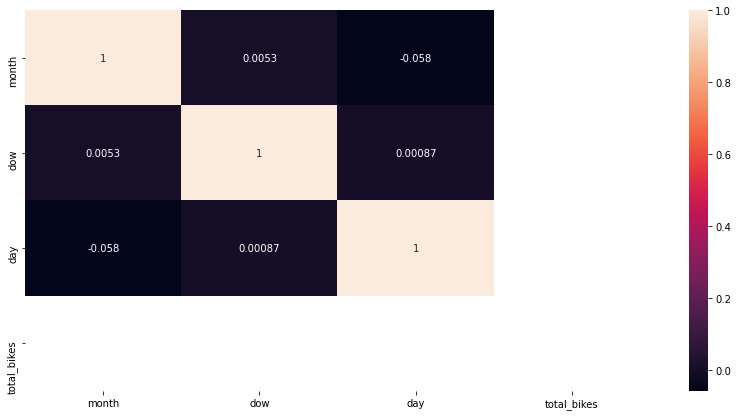

In [14]:
# correlation between month, day of week and the number of bokes
data_corr=df[["month","dow","day","total_bikes"]]
plt.figure(figsize=(14,7))
sns.heatmap(data_corr.corr(),annot=True)
plt.show()

Month and total bikes has only strong positive correlation. Day of the week and day have weak positive and negative correlations

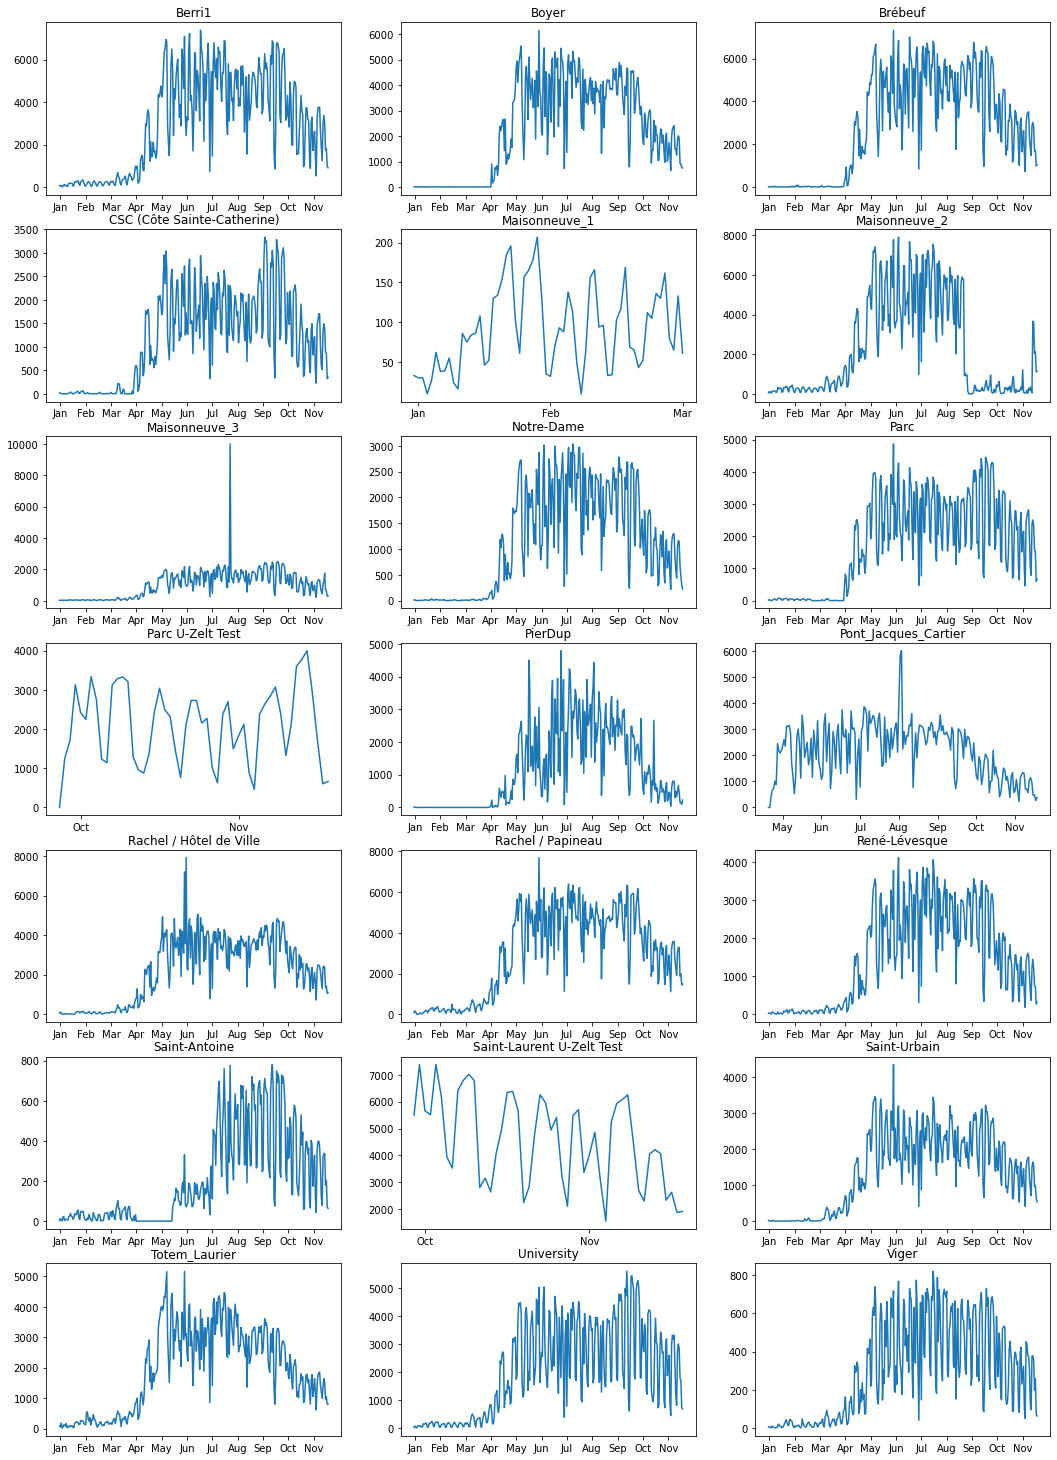

In [15]:
# Plot each lane by month
fig = plt.figure(figsize = (18, 26))

columns = 3
rows = 7

ax = []
#extract month names
months = list(df.Date_dt.dt.month_name().unique())
#shorten month names
mon = [mon[:3] for mon in months]

for i in range(columns * rows):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[i].set_title(cols_lanes[i])
    plt.setp(ax,xticks=np.arange(1,319,30), xticklabels=mon)
for i in range(len(cols_lanes)):
    ax[i].plot(df['Date'], df[cols_lanes[i]])
    

Some lanes are not operating during the whole year. But for all of the the winter months are the months with fewer bikers.

We can also see a box plot to get a better idea of a number of bikers.

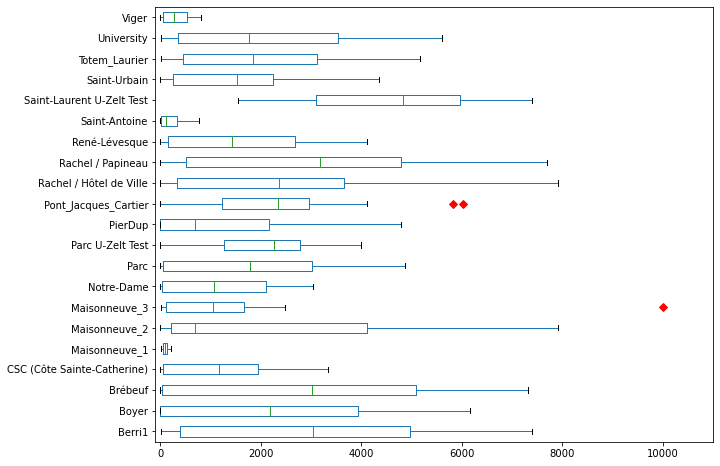

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))
df[cols_lanes].plot(kind='box', sym='rD', vert=False, xlim=(-100,11000), ax = ax)
plt.show()

In [17]:
# PyTorch regression model

In [18]:
df.isnull().sum(axis = 0)

Date                             0
Berri1                           0
Boyer                            0
Brébeuf                          0
CSC (Côte Sainte-Catherine)      0
Maisonneuve_1                  257
Maisonneuve_2                    0
Maisonneuve_3                    0
Notre-Dame                       0
Parc                             0
Parc U-Zelt Test               267
PierDup                          0
Pont_Jacques_Cartier           110
Rachel / Hôtel de Ville          0
Rachel / Papineau                0
René-Lévesque                    0
Saint-Antoine                    0
Saint-Laurent U-Zelt Test      269
Saint-Urbain                     0
Totem_Laurier                    0
University                       0
Viger                            0
Date_dt                          0
day                              0
month                            0
dow                              0
total_bikes                    319
dtype: int64

In [19]:
#=================================================================================================================

In [20]:
df = pd.read_csv(os.path.join(cwd, 'montrealbikes.csv'))


In [21]:
# Hyperparameters
batch_size=150
learning_rate=1e-10


# Other constants
DATA_FILENAME = os.path.join(cwd, 'montrealbikes.csv')
TARGET_COLUMN = 'Viger' # We chose one bike lane as our dependent variable
input_size=16
output_size=1

In [22]:
# Download the data
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10


In [23]:
dataframe = dataframe.drop(columns=['Maisonneuve_1', 'Parc U-Zelt Test', 'Pont_Jacques_Cartier', 'Saint-Laurent U-Zelt Test'])
dataframe.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10


In [24]:
dataframe = dataframe.drop(columns=['Unnamed: 1', 'Date'])
dataframe.head()

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,PierDup,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Urbain,Totem_Laurier,University,Viger
0,58,12,4,17,49,21,16,16,7,58,91,24,3,17,78,21,6
1,75,7,5,15,113,27,9,32,11,109,177,32,13,11,57,77,4
2,79,7,3,7,107,36,12,18,2,71,131,33,5,14,174,40,5
3,10,1,21,0,35,29,1,0,0,6,11,6,1,1,20,6,0
4,42,0,2,0,90,21,1,1,6,0,5,49,20,0,41,56,10


In [25]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop(TARGET_COLUMN, axis=1).values
targets = dataframe[[TARGET_COLUMN]].values
inputs.shape, targets.shape

((319, 16), (319, 1))

In [26]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [255, 64])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [44]:
class LinearFunction(Function):
    
    @staticmethod
    def forward(ctx, input, weight): #, bias = None):
#         ctx.save_for_backward(input, weight, bias)
        ctx.save_for_backward(input, weight)
        
        output = input.mm(weight.t()) #mm - multpl, t - transpose
        return output
    
    
    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
#         print('weight', weight)
        grad_input = grad_weight = None
        
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(input)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.mm(weight)
    
        return grad_input, grad_weight




In [39]:
input_size = 16
output_size = 1

class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(Linear, self).__init__()
        self.input_features = input_size
        self.output_features = input_size
        
    
        self.weight = nn.Parameter(torch.empty(output_size, input_size))
      

        # initialize weights
        nn.init.uniform_(self.weight, -1, 1)
   
    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight)#, self.bias)
    

In [29]:
# create a custom loss MAE
def mae_custom(output, target):
    loss =torch.mean(torch.abs(output - target))
    return loss

In [30]:
# create a custom loss MSE
def mse_custom(output, target):
    loss = torch.mean((output - target)** 2)
    return loss

In [31]:
def numpy_spearman(target, pred):
    pred = pd.Series(pred.detach().numpy().squeeze())
    target = pd.Series(target.detach().numpy().squeeze())
    
    corr = np.corrcoef(target, pred.rank(pct=True, method="first"))[0, 1]
    corr = torch.tensor(corr, requires_grad=True)
    return corr

In [32]:
def custom_spearman(output, target):
    vx = output - torch.mean(output)
    vy = target - torch.mean(target)

    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    return cost

In [45]:
torch.autograd.set_detect_anomaly(True)
model = Linear(input_size, output_size)
train_losses = []
val_losses = []

optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        
        #predictions
        out = model(inputs)                   # Generate predictions
        
#         loss = custom_spearman(out, targets)  
        
        loss = mae_custom(out, targets)  
#         loss = numpy_spearman(out, targets)  
#         loss = mse_custom(out, targets)    
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                #predictions
                val_out = model(val_inputs)                   # Generate predictions
                val_loss = mae_custom(val_out, val_targets)  
                val_losses.append(val_loss)

    print(f'epoch {epoch}, loss {loss}')    

    

epoch 0, loss 2233.670166015625
epoch 1, loss 1659.687744140625
epoch 2, loss 2219.96142578125
epoch 3, loss 1920.148193359375
epoch 4, loss 1546.1510009765625
epoch 5, loss 1891.070556640625
epoch 6, loss 1743.3369140625
epoch 7, loss 1932.5931396484375
epoch 8, loss 1942.9920654296875
epoch 9, loss 1662.76416015625
epoch 10, loss 1911.3609619140625
epoch 11, loss 1823.622314453125
epoch 12, loss 1805.50732421875
epoch 13, loss 1697.015625
epoch 14, loss 1710.3978271484375
epoch 15, loss 1544.3289794921875
epoch 16, loss 1475.20654296875
epoch 17, loss 1530.3048095703125
epoch 18, loss 1373.648681640625
epoch 19, loss 1181.017333984375
epoch 20, loss 1575.28173828125
epoch 21, loss 1554.574951171875
epoch 22, loss 1551.766357421875
epoch 23, loss 1351.0142822265625
epoch 24, loss 1418.514404296875
epoch 25, loss 1275.6575927734375
epoch 26, loss 1405.787109375
epoch 27, loss 1370.7440185546875
epoch 28, loss 1266.843994140625
epoch 29, loss 1309.44775390625
epoch 30, loss 1241.3096923

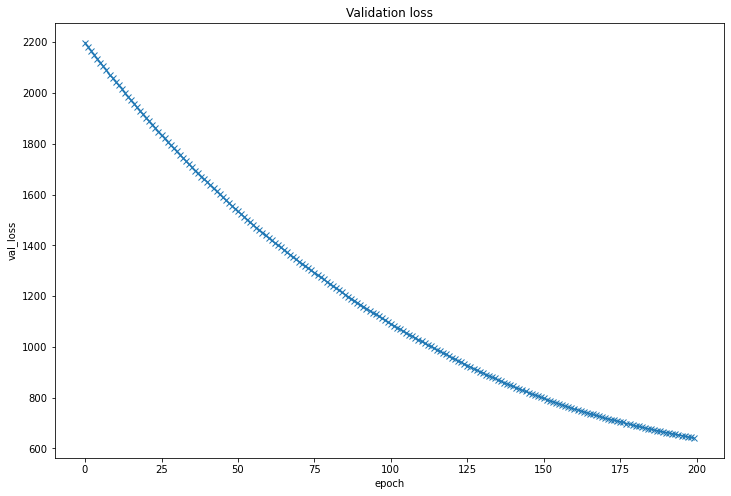

In [46]:
fig, axes = plt.subplots(figsize = (12, 8))
plt.plot(val_losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Validation loss')
plt.show()

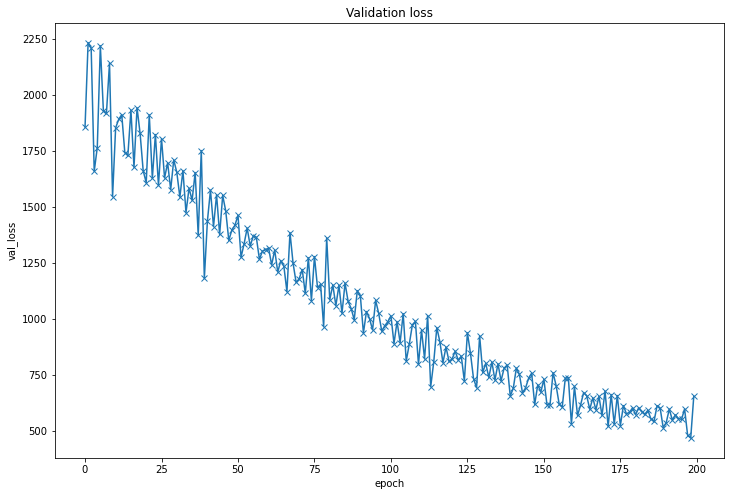

In [48]:
fig, axes = plt.subplots(figsize = (12, 8))
plt.plot(train_losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Validation loss')
plt.show()

In [36]:
class BikeLaneModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
#     def forward(self, xb):
#         out = self.linear(xb)
#         return out
        
    def forward(self, input):
        return LinearFunction.apply(input, self.weight, self.bias)
    
    
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                   # Generate predictions
        loss = F.mse_loss(out, targets)      # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                   # Generate predictions      
        loss = F.mse_loss(out, targets)      # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        if epoch % 20 == 0:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [37]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
model = BikeLaneModel()
result = evaluate(model, val_loader)
result

AttributeError: 'BikeLaneModel' object has no attribute 'weight'

In [ ]:
history = fit(250, learning_rate, model, train_loader, val_loader)

In [ ]:

losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('Validation loss')
losses[-1]